In [1]:
%cd '/content/drive/MyDrive/CV_ENG_8160/Homework01'

/content/drive/MyDrive/CV_ENG_8160/Homework01


In [2]:
!ls

 Data  'Homework 01_Praveen.ipynb'


In [3]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
# Ignore warnings
import warnings
import time
import random
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
class CustomDataset(Dataset):
    def __init__(self, classification_root, localization_root, transform=None, is_localization=False):
        self.classification_root = Path(classification_root)
        self.localization_root = Path(localization_root)

        if is_localization:
            loc_df = pd.read_csv(self.localization_root / 'train.csv')
            self.loc_labels = loc_df[['x', 'y', 'width', 'height']].values

            # Randomly select an image from any subfolder
            rand_loc_image = np.random.choice(os.listdir(self.localization_root / 'classd'))
            # Add '00' prefix to match image names in the folder
            rand_loc_image = '00' + rand_loc_image
            self.loc_image_names = [str(self.localization_root / 'classd' / rand_loc_image)]

        else:
          class_df = pd.read_csv(self.classification_root / 'train.csv')
          self.class_labels = class_df['img_name'].values

          # Get the list of subfolders in the classd folder
          data_subfolders = os.listdir(self.classification_root / 'data')

          # Randomly select an image from any subfolder
          rand_class_folder_name = np.random.choice(data_subfolders)
          rand_class_image = np.random.choice(os.listdir(self.classification_root / 'data' / rand_class_folder_name))
          self.image_names = [str(self.classification_root / 'data' / rand_class_folder_name / rand_class_image)]

        self.transform = transform

    def __len__(self):
        if hasattr(self, 'image_names'):
            return len(self.image_names)
        elif hasattr(self, 'loc_image_names'):
            return len(self.loc_image_names)
        else:
            return 0


    def __getitem__(self, idx):
        if hasattr(self, 'image_names'):
            # Get the subfolder name for the current index
            subfolder_name = Path(self.image_names[idx]).parent.name
            # Read the image using the skimage library
            image_data = io.imread(self.image_names[idx])

            sample = {'image': image_data, 'class_label': subfolder_name}

        elif hasattr(self, 'loc_image_names'):
            # Get the image path for the current index
            image_path = self.loc_image_names[idx]
            # Read the image using the skimage library
            image_data = io.imread(image_path)

            # Get localization labels for the current index
            loc_label = self.loc_labels[idx]

            sample = {'image': image_data, 'loc_label': loc_label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        class_label = sample.get('class_label', None)
        loc_label = sample.get('loc_label', None)

        if isinstance(image, np.ndarray):
            # Ensure the image is in uint8 format
            image = image.astype(np.uint8)

            # If NumPy array, rescale using NumPy operations
            h, w = image.shape[:2]
            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            img = np.array(Image.fromarray(image).resize((new_w, new_h)))
        elif isinstance(image, torch.Tensor):
            # If PyTorch tensor, rescale using PyTorch functions
            to_pil = transforms.ToPILImage()
            to_tensor = transforms.ToTensor()

            img = to_tensor(transforms.Resize(self.output_size)(to_pil(image)))

        return {'image': img, 'class_label': class_label, 'loc_label': loc_label}


In [6]:
class Flip(object):
    def __init__(self, flip):
        assert flip in [0, 1], "flip argument must be 0 or 1"
        self.flip = flip

    def __call__(self, sample):
        image, class_label, loc_label = sample['image'], sample.get('class_label', None), sample.get('loc_label', None)

        # Check if the image is a PyTorch tensor or a NumPy array
        if isinstance(image, torch.Tensor):
            # If PyTorch tensor, apply flip using PyTorch functions
            image = torch.flip(image, [2]) if self.flip == 1 else image
        else:
            # If NumPy array, apply flip using NumPy functions
            image = np.flip(image, axis=1) if self.flip == 1 else image

        sample = {'image': image, 'class_label': class_label, 'loc_label': loc_label}
        return sample


In [7]:
class ToTensor(object):
    def __call__(self, sample):
        image, class_label, loc_label = sample['image'], sample['class_label'], sample['loc_label']

        # Ensure the image is in channel-last format (H x W x C) before converting to tensor
        image = image.transpose((2, 0, 1)).copy()

        return {'image': image, 'class_label': class_label, 'loc_label': loc_label}



In [8]:
def plot_images(images, class_labels, loc_labels):
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))  # Assuming images are in channel-first format
        ax.set_title(f"Class: {class_labels[i]}\nLoc: {loc_labels[i]}")
        ax.axis('off')
    plt.show()

In [9]:
classification_root = '/content/drive/MyDrive/CV_ENG_8160/Homework01/Data/classification'
localization_root = '/content/drive/MyDrive/CV_ENG_8160/Homework01/Data/localize'
transform = transforms.Compose([Rescale(256), Flip(0), ToTensor()])

# Create instances of the CustomDataset for localization and classification separately
localization_dataset = CustomDataset(classification_root, localization_root, transform=transform)
classification_dataset = CustomDataset(classification_root, localization_root, transform=transform)

# Randomly select an index from each dataset
random_index_loc = np.random.randint(len(localization_dataset))
random_index_class = np.random.randint(len(classification_dataset))

# Get random samples from each dataset
random_sample_loc = localization_dataset[random_index_loc]
random_sample_class = classification_dataset[random_index_class]

(256, 459, 3)


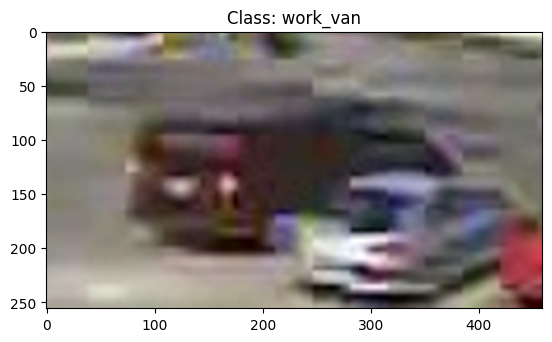

In [10]:
img_out = random_sample_class['image'].transpose((1, 2, 0))
plt.imshow(img_out)
plt.title(f"Class: {random_sample_class['class_label']}")
print(img_out.shape)


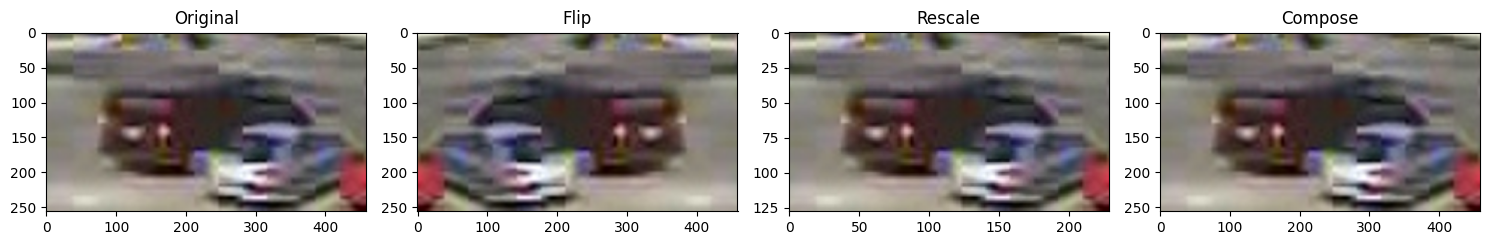

In [11]:
# Create a single axis for all four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Original Image
axes[0].imshow(img_out)
axes[0].set_title("Original")

transforms_list = [Flip(1), Rescale(128), transforms.Compose([Rescale(256), Flip(0)])]

for i, transform in enumerate(transforms_list, start=1):
    # print(type(transform).__name__)

    sample = transform({'image': img_out})

    axes[i].imshow(sample['image'])
    axes[i].set_title(type(transform).__name__)

plt.tight_layout()
plt.show()


(256, 256, 3)


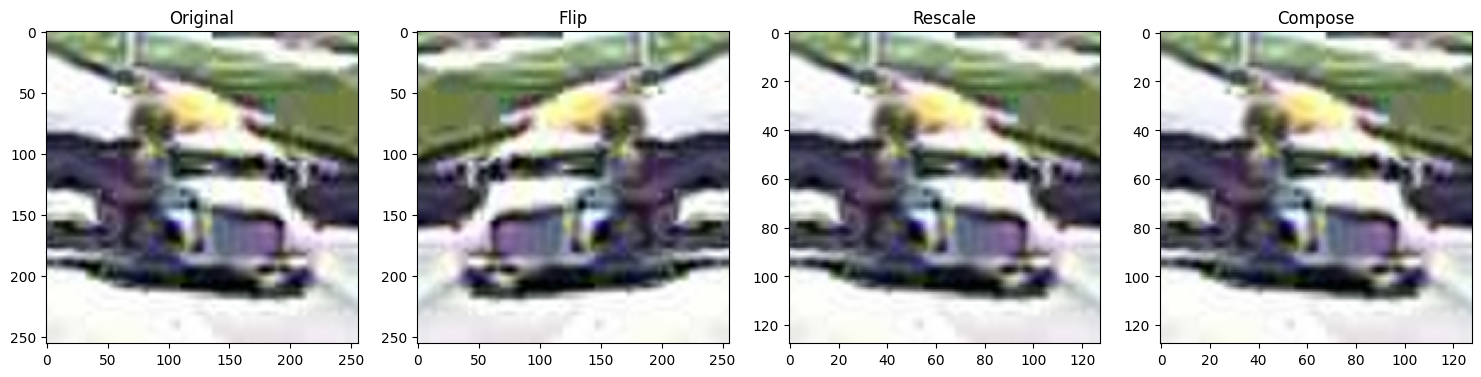

In [12]:
# Create a single axis for all four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Random image from localize dataset
img_out_loc = random_sample_loc['image'].transpose((1, 2, 0))
plt.imshow(img_out_loc)
print(img_out_loc.shape)
axes[0].imshow(img_out_loc)
axes[0].set_title("Original")

transforms_list = [Flip(1), Rescale(128), transforms.Compose([Rescale(128), Flip(0)])]

for i, transform in enumerate(transforms_list, start=1):
    # print(type(transform).__name__)

    sample = transform({'image': img_out_loc})

    axes[i].imshow(sample['image'])
    axes[i].set_title(type(transform).__name__)

plt.tight_layout()
plt.show()